# Simple Multi-Class Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import cm
import seaborn as sns 

from matplotlib import cm
from tqdm import tqdm

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from macest.classification import models as clmod
from macest.classification import utils as clut
from macest.classification import plots as clplot
from macest.classification.metrics import expected_calibration_error
from macest.model_selection import KFoldConfidenceSplit

from plotting_utils import (make_funky_star, make_star_classes, plot_prediction_conf_surface_multiclass, 
                            plot_macest_sklearn_comparison_surface_multiclass)

In [3]:
sns.set_context("notebook")
sns.set_style('darkgrid')

### Generate a multi-class star

In [4]:
n_arms = 4
n_points = 4 *10**4
n_classes = 4
n_points_per_arm = n_points/(n_arms)

In [5]:
X = make_funky_star(n_arms, n_points)

In [6]:
y = make_star_classes(n_arms, n_points, n_classes)

In [7]:
y = y.astype(int)

Text(0, 0.5, 'x2')

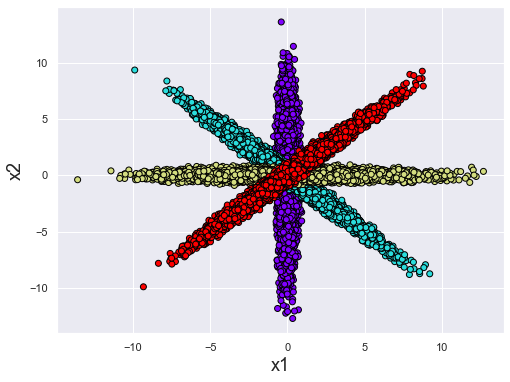

In [8]:
plt.figure(figsize = (8,6))
plt.scatter(X[:,0], X[:,1], c = y,cmap = cm.rainbow, edgecolors='black')
plt.xlabel('x1', fontsize = 18)
plt.ylabel('x2', fontsize = 18)

## Splitting the Data into 4 sets
1. The training data for the point prediction model
2. data used to build a graph of known labelled data for the confidence model
3. Data to calibrate MACE parameters
4. Unseen testing data

In [9]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X, y, test_size=0.6, random_state=0)
X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.4, random_state=0)
X_cal, X_test, y_cal,  y_test, = train_test_split(X_cal, y_cal, test_size=0.4, random_state=0)

## Train a point prediction model

In [10]:
model = RandomForestClassifier(n_estimators = 100, random_state=0)
model.fit(X_pp_train, y_pp_train)

RandomForestClassifier(random_state=0)

In [11]:
print(model.score(X_conf_train, y_conf_train))
print(model.score(X_cal, y_cal))

0.8644444444444445
0.8715277777777778


## Let's train MACEst, In the cell below we will specify the hnsw args which will define our notion of similarity and the graph/search parameters

In [12]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train)

macest_model.fit(X_cal, y_cal)

#### We can change the MACEst defaults if we want as shown below by editing the NamedTuple for each parameter

In [13]:
clmod.SearchBounds()

SearchBounds(alpha_bounds=(0.1, 100.0), beta_bounds=(0.1, 100.0), k_bounds=(5, 40), temperature_bounds=(0, 40))

In [14]:
clmod.HnswGraphArgs()

HnswGraphArgs(init_args={'method': 'hnsw', 'space': 'l2'}, construction_args={'post': 2, 'efConstruction': 1000, 'M': 100}, query_args={'ef': 1000})

In [15]:
param_bounds = clmod.SearchBounds(k_bounds = (5,15))
neighbour_search_params = clmod.HnswGraphArgs(query_args = dict(ef = 1100))

#### Optimiser args are the arguments passed to scipy differential evolution and must be passed as a dictionary

In [16]:
optimiser_args = dict(popsize = 15)

In [17]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args =neighbour_search_params)

macest_model.fit(X_cal,
               y_cal,
               param_range = param_bounds,
               optimiser_args = optimiser_args)

### In the plot below we see that the random forest model partitions the space into 4 classes, this partitioning is effective very close to the data however does not make much sense elsewhere, i.e. at ~10 degrees away from the vertical the model predicts red with very high confidence
### This partitioning also means that confidence does not decrease far away from the data as the confidence is also effectively partitioned

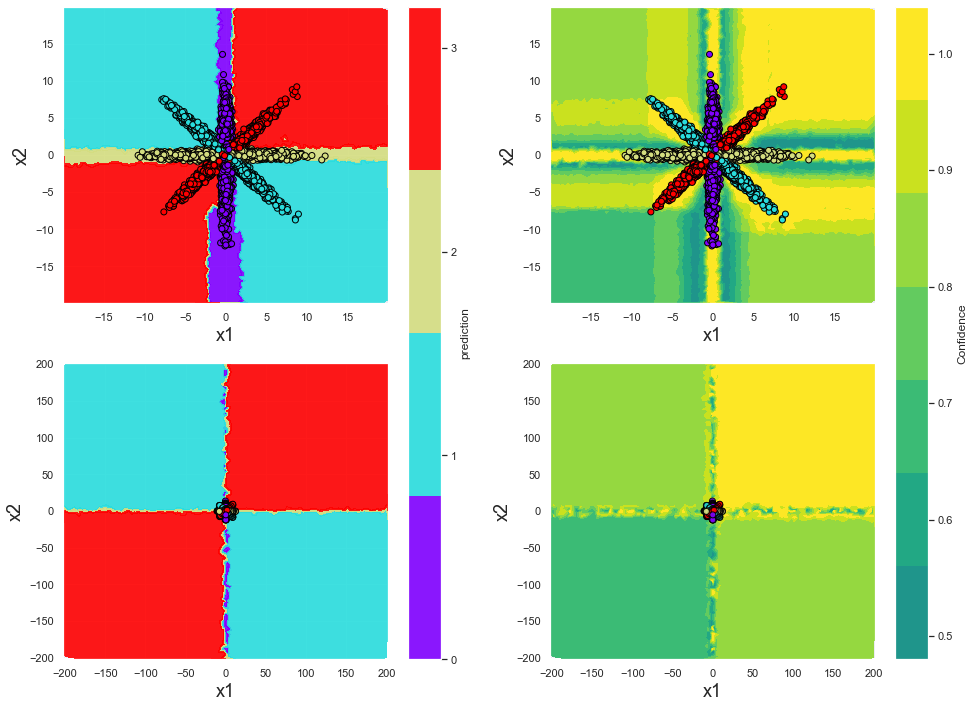

In [18]:
plot_prediction_conf_surface_multiclass(20, 202, model, X_pp_train, y_pp_train)

### Partitioning the space effectively learns a global model, MACE is fundamentally different in that it treats confidence as a local quantity, this is apparent in the bottom plot when we try to extrapolate away from the data

MACEst confidence (as default) shows the confidence that the point prediction is correct, this is not necessarily the max MACEst confidence score however we believe that this is a more useful metric as MACEst is not designed to be a classifer (and in general will likely not perform as well globally as other classifiers), it is meant to be used to indicate how much one should trust a point prediction.

An example of this can be seen below, the model only predicts blue for a very thin slice, either side of this strip it predicts a different class, so the MACEst confidence score is almost 0 implying it thinks it's more likely that it's a different class. A confidence score this low would indicate that this prediction is strange in some way

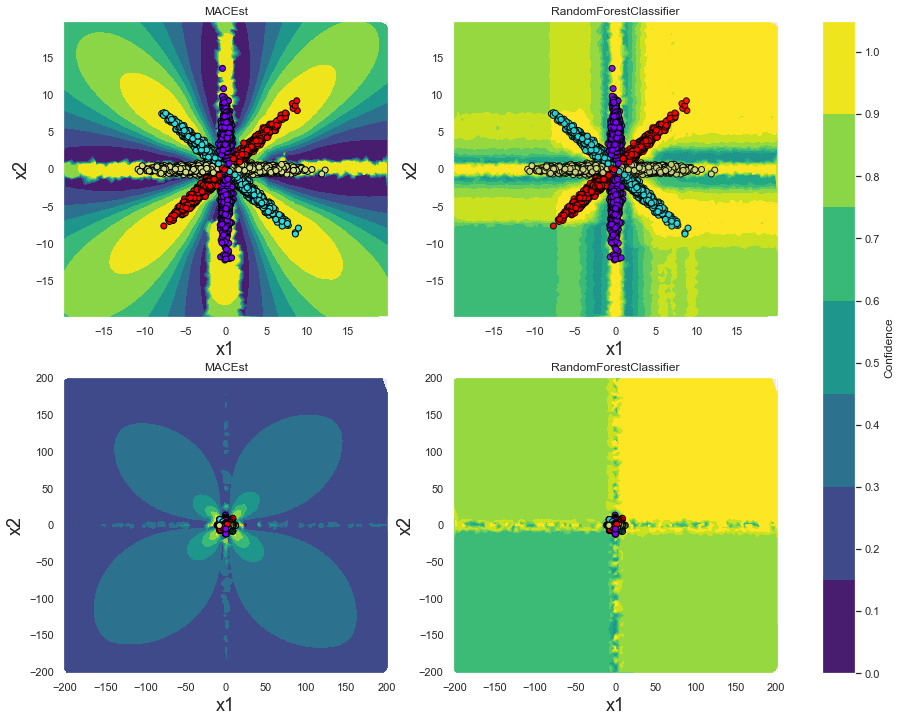

In [19]:
plot_macest_sklearn_comparison_surface_multiclass(20, 202, macest_model, model, X_pp_train, y_pp_train)

## Let's observe the effect of changing the similarity metric

## L1

In [20]:
neighbour_search_params = clmod.HnswGraphArgs(init_args = dict(method = 'hnsw', 
                                                               space = 'l1'))

In [21]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args = neighbour_search_params)

macest_model.fit(X_cal, y_cal, param_range = param_bounds, optimiser_args= optimiser_args)

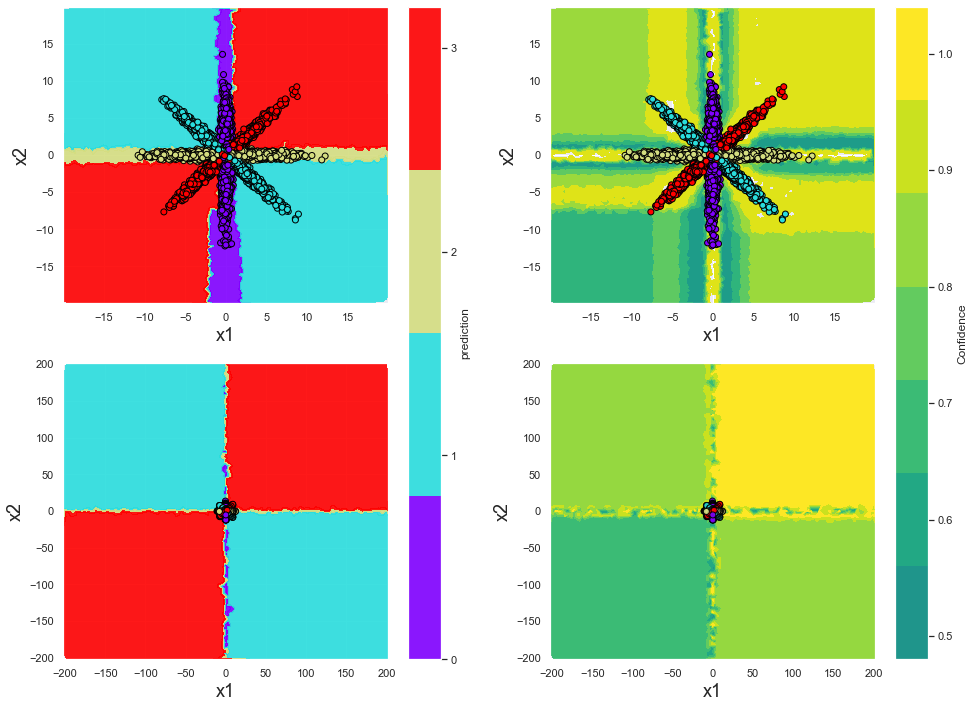

In [22]:
plot_prediction_conf_surface_multiclass(20, 202, model, X_pp_train, y_pp_train)

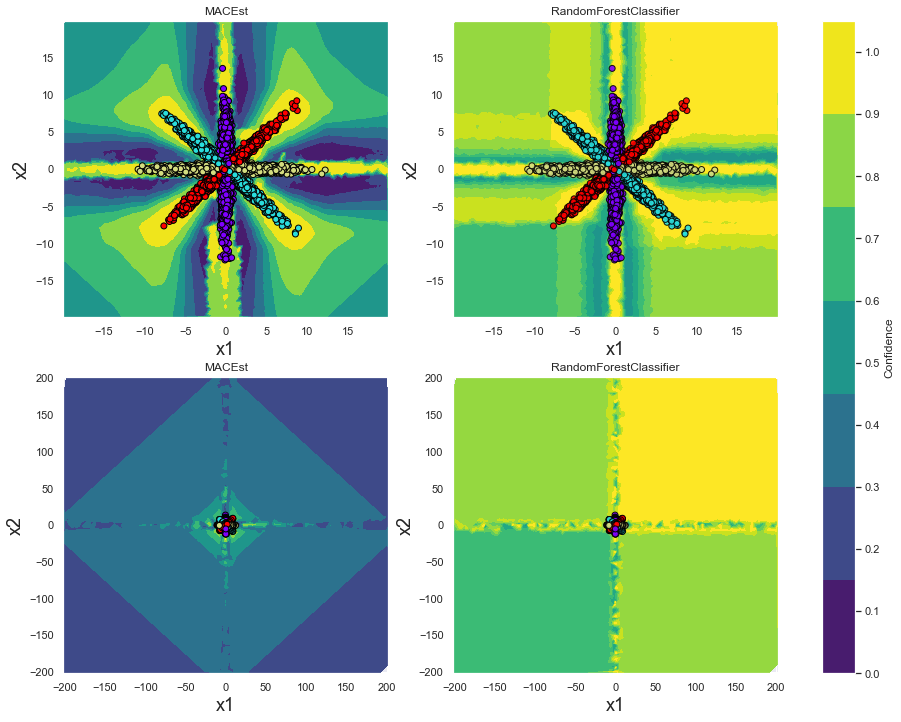

In [23]:
plot_macest_sklearn_comparison_surface_multiclass(20, 202, macest_model, model, X_pp_train, y_pp_train)

## Cosine

Cosine similarity is useful if we believe that data points are similar if they have the same angle, i.e. if they point in the same direction. The length of this vector is not important

In [24]:
neighbour_search_params = clmod.HnswGraphArgs(init_args = dict(method = 'hnsw', 
                                                               space = 'cosinesimil'))

In [25]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args = neighbour_search_params)

macest_model.fit(X_cal, y_cal, param_range = param_bounds, optimiser_args= optimiser_args)

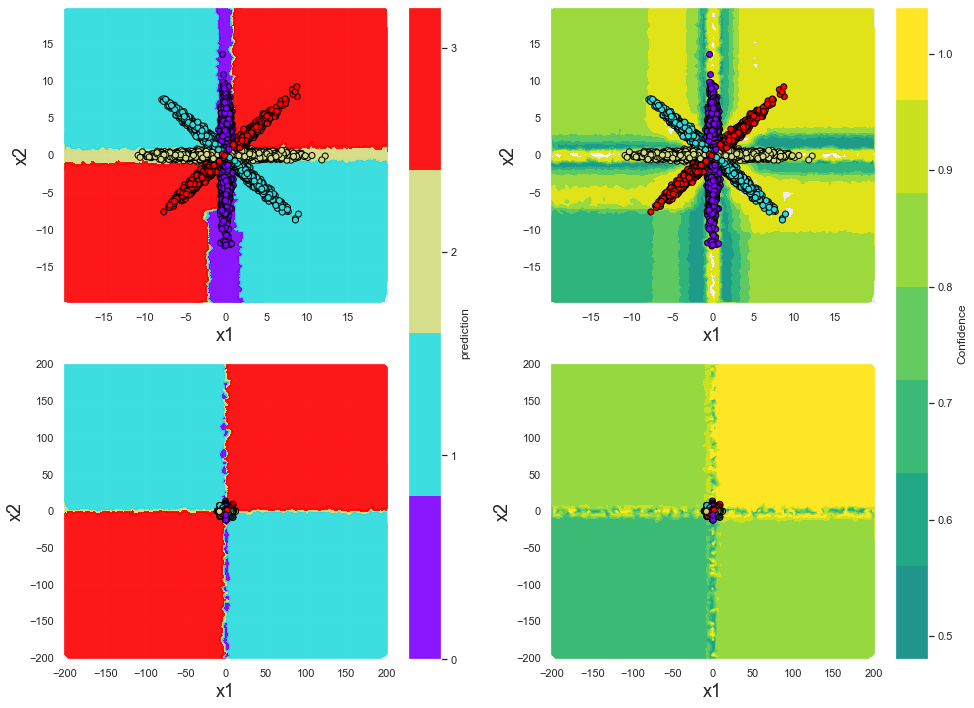

In [26]:
plot_prediction_conf_surface_multiclass(20, 202, model, X_pp_train, y_pp_train)

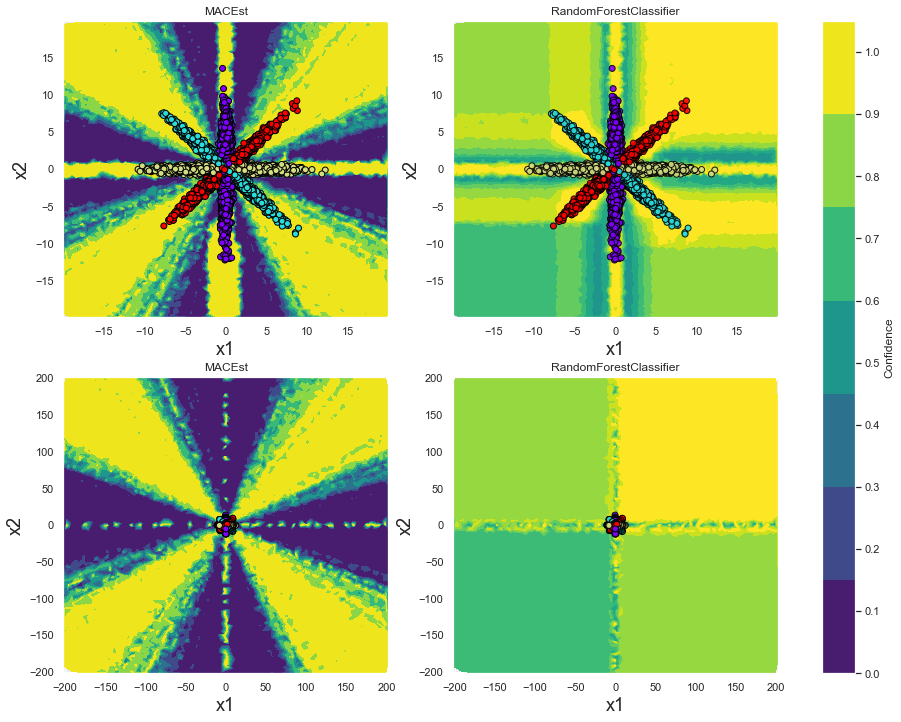

In [27]:
plot_macest_sklearn_comparison_surface_multiclass(20, 202, macest_model, model, X_pp_train, y_pp_train)

### Angular Distance

Angular distance is very similar to the cosine distance however it is transformed such that it's a proper metric

In [28]:
neighbour_search_params = clmod.HnswGraphArgs(init_args = dict(method = 'hnsw', 
                                                               space = 'angulardist'))

In [29]:
macest_model = clmod.ModelWithConfidence(model,
                                      X_conf_train,
                                      y_conf_train, 
                                      search_method_args = neighbour_search_params)

macest_model.fit(X_cal, y_cal, param_range = param_bounds, optimiser_args= optimiser_args)

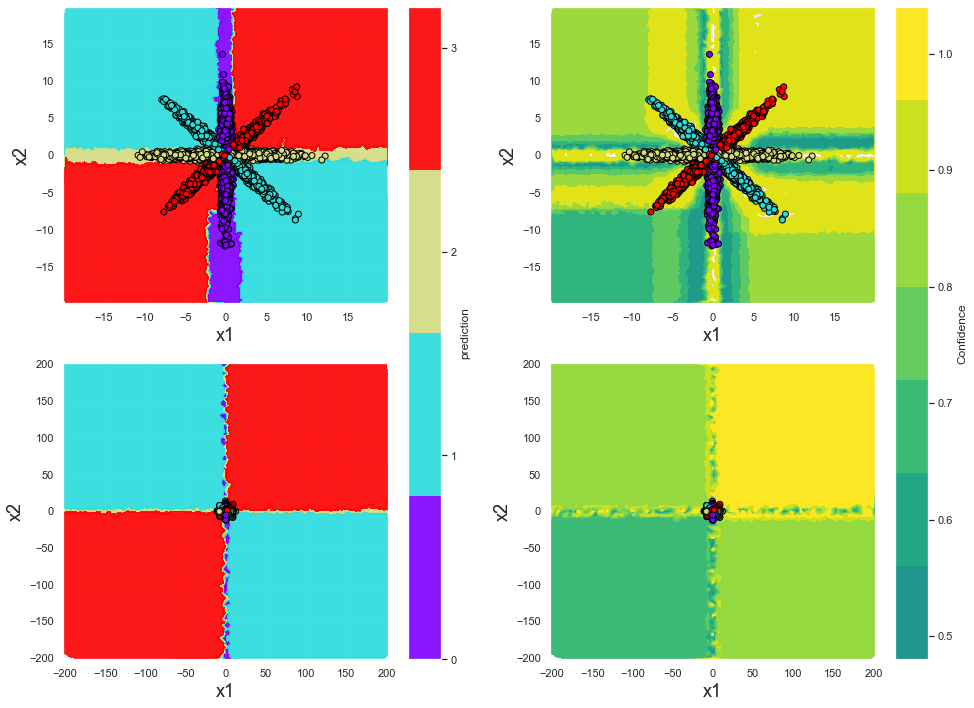

In [30]:
plot_prediction_conf_surface_multiclass(20, 202, model, X_pp_train, y_pp_train)

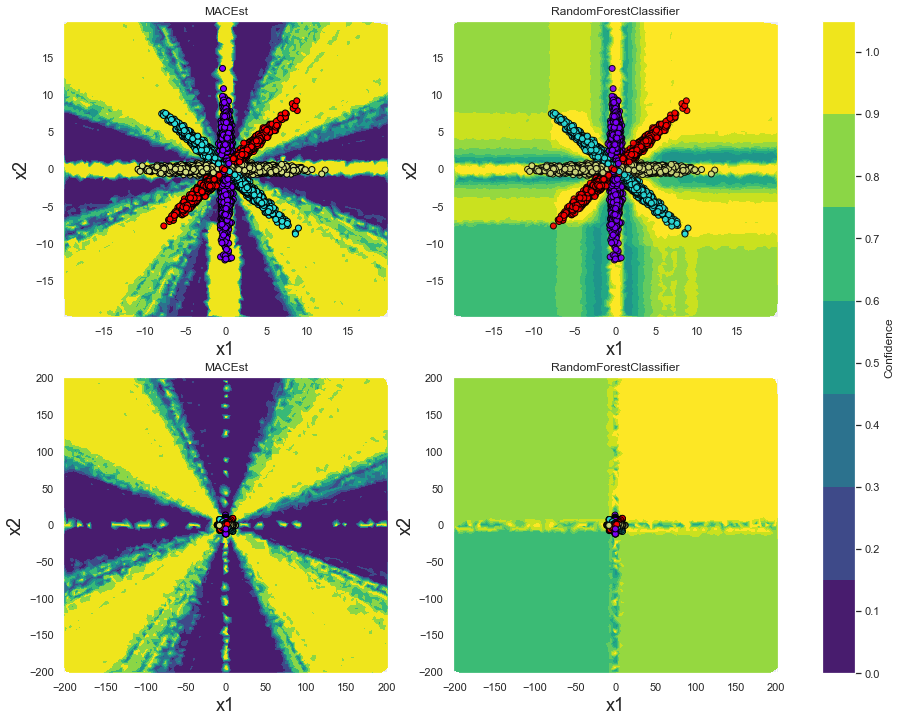

In [31]:
plot_macest_sklearn_comparison_surface_multiclass(20, 202, macest_model, model, X_pp_train, y_pp_train)

### If we Wanted to go K fold with MACEst we need to use the modified Kfold to ensure that the 4 splits are done correctly
#### the default is to use 1./nsplits as test data, then of the remaining data split that  as
1. 50% point pre
2. 30% To build graph
3. 20% to calibrate MACEst parameters

In [32]:
kfold = KFoldConfidenceSplit(n_splits =5, shuffle = True)

In [33]:
n_arms = 4
n_points = 10**3
n_classes = 4

In [34]:
X = make_funky_star(n_arms = 4,
                    n_points= n_points)

y = make_star_classes(n_arms=4,
                      n_points=n_points,
                      n_classes= 4)
y = y.astype(int)

In [35]:
ece = []

for train_idxs, conf_cal_idxs, conf_graph_idxs, test_idxs in kfold.split(X):
        
    X_pp_train = X[train_idxs]
    y_pp_train =  y[train_idxs]
    
    X_test = X[test_idxs]
    y_test = y[test_idxs]
    
    X_cal = X[conf_cal_idxs]
    y_cal = y[conf_cal_idxs]
    
    X_graph = X[conf_graph_idxs]
    y_graph = y[conf_graph_idxs]
    

    model = RandomForestClassifier(random_state =0,
                               n_estimators =500)
    
    model.fit(X_pp_train, y_pp_train)
    
    model_preds = model.predict(X_test)    
    macest_model = clmod.ModelWithConfidence(model,
                                      X_graph,
                                      y_graph)
    

    macest_model.fit(X_cal, y_cal)
    ece.append(expected_calibration_error(model_preds,
                                          y_test,
                                          macest_model.predict_confidence_of_point_prediction(X_test)))
    

Text(0.5, 0, 'ECE')

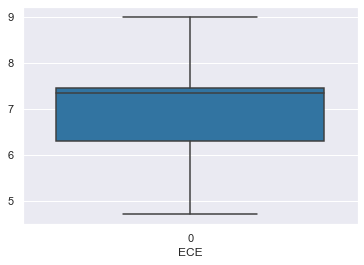

In [36]:
sns.boxplot(ece)
plt.xlabel('ECE')